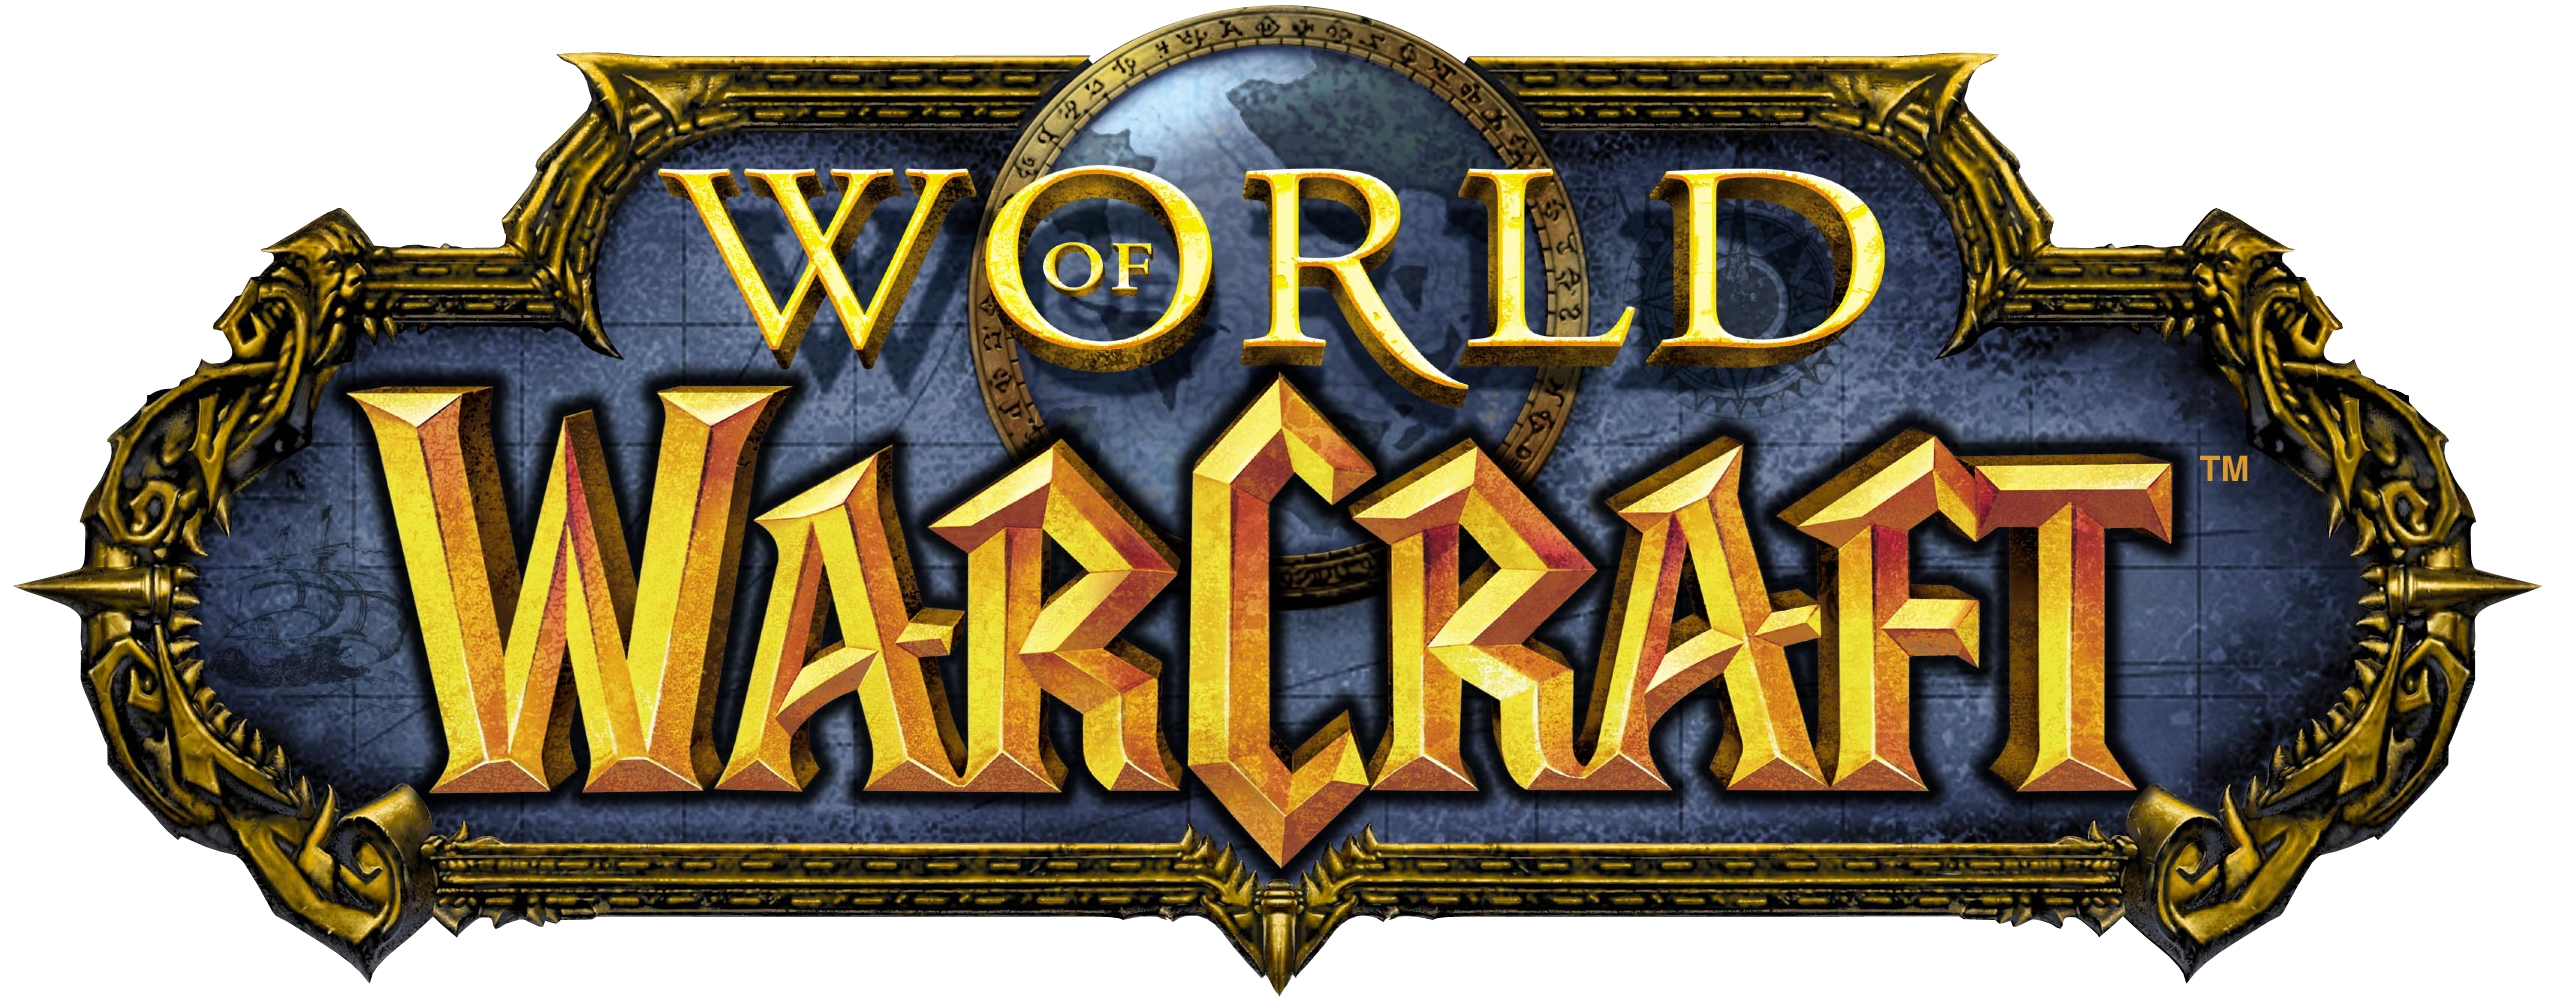

In [1]:
from IPython.display import Image, display

display(Image(filename='World_of_Warcraft_logo.jpg'))


## Objective
* Complete Exploratory Data Analysis.
* Complete Survival Analysis.
* Predict if a user will churn in a six-month period using multi-task learning model.

## Background Information
* World of Warcraft is a massively multiplayer online video game released on November 23, 2004. Before this era, MMORPG’s catered to a small segment of video gamers. But with the massive success of WoW, various video game companies decided to invest resources into developing large-scale titles. Video games were sought out as movie-like experiences, where you follow a single protagonist. However, WoW did not follow a single protagonist, but all the users playing the video game. Not only was the main objective different from single-player games, but the pricing model. Traditional games followed a single upfront fee. In addition to the single upfront fee, WoW had a monthly subscription to play the game. With customer subscriptions in mind, we can apply the use of churn prediction to not only predict whether a customer will unsubscribe from the service but explore the user’s playing behavior to obtain more insight into user playing patterns. The churn problem is somewhat complex due to the nature of not having a one size fits all solution – as different services define churn in a variety of ways.

## Process:
* Exploratory Data Analysis conducted utilizing various python packages (Numpy, Matplotlib, Pandas, and Plotly).'
* Survival Analysis (Lifelines)
    * Kaplan Meier Estimator
* Binary Classification Algorithms (Sci-Kit Learn)
    * Logistic Regression
    * Support Vector Machines
    * K-nearest neighbors
    * Random Forests



## Table of Contents:
* Part I: Exploratory Data Analysis
    * EDA
* Part II: Churn Prediction
    * Multi-Task Model

In [3]:
pip install lifelines

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl (11.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [39]:
pip show scikit-learn

Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYR

In [6]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import rmst_plot
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
# Optional: If class imbalance is detected
from imblearn.over_sampling import SMOTE

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings
import torch

warnings.filterwarnings("ignore")

# PART I - Exploratory Data Analysis

### Data Preprocessing / Feature Engineering

Let us begin by reading in the CSV file containing the data, and examining the data contents such as the number of features and the number of samples. It seems there are 7 column entries (features) and 10826734 row entries (number of samples).

In [10]:
#--------- Pandas Dataframe
## Read in CSV
avatar_history = pd.read_csv('data/wowah_data.csv')

## Examine data contents
avatar_history.info()
avatar_history.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826734 entries, 0 to 10826733
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   char        int64 
 1    level      int64 
 2    race       object
 3    charclass  object
 4    zone       object
 5    guild      int64 
 6    timestamp  object
dtypes: int64(3), object(4)
memory usage: 578.2+ MB


char   level  race  charclass                zone   guild  \
0  59425       1   Orc      Rogue           Orgrimmar     165   
1  65494       9   Orc     Hunter             Durotar      -1   
2  65325      14   Orc    Warrior          Ghostlands      -1   
3  65490      18   Orc     Hunter          Ghostlands      -1   
4   2288      60   Orc     Hunter  Hellfire Peninsula      -1   

           timestamp  
0  01/01/08 00:02:04  
1  01/01/08 00:02:04  
2  01/01/08 00:02:04  
3  01/01/08 00:02:04  
4  01/01/08 00:02:09

* char = the character id
* level = level of the character
* race = race of the character
* charclass = class of the character
* zone = location at which the character is
* guild = guild id of the character
* timestamp = date and time at which the entry took place


Remove unwanted whitespace in column names.

In [13]:
# Strip whitespace in feature names
avatar_history.rename(columns = lambda x: x.strip(), inplace = True)
avatar_history.columns

Index(['char', 'level', 'race', 'charclass', 'zone', 'guild', 'timestamp'], dtype='object')

Split the date from the time from the timestamp feature.

In [15]:
def time_transform(x):
    "Function to split the date and time"
    y = x.split()[0]
    return y[:-2] + '20' + y[-2:]

In [16]:
## Create new features date and time using the function above
avatar_history['date'] = avatar_history['timestamp'].apply(time_transform)
avatar_history['time'] = avatar_history['timestamp'].apply(lambda x: x.split()[1][:-4] + '0')

The timestamps feature was converted into a DateTime object, allowing us to extract the month, day, and time of each entry. 

In [18]:
# Create datetime features 
avatar_history['timestamp'] = pd.to_datetime(avatar_history['timestamp'])
avatar_history['Month'] = avatar_history['timestamp'].dt.month
avatar_history['Day'] = avatar_history['timestamp'].dt.dayofyear
avatar_history['Weekday'] = avatar_history['timestamp'].dt.weekday

### Feature Exploration

The number of unique entries for each feature is organized in Table 1.  

In [21]:
# Table of feature description
## Find the number of unique entries for each feature
number_of_characters = avatar_history['char'].nunique()
number_of_levels = avatar_history['level'].nunique()
number_of_races = avatar_history['race'].nunique()
number_of_classes = avatar_history['charclass'].nunique()
number_of_zones = avatar_history['zone'].nunique()
number_of_guilds = avatar_history['guild'].nunique()
number_of_timestamps = avatar_history['timestamp'].nunique()

## Append and print the unique entries for each feature
data = []
for x in avatar_history.columns:
    print("The number of unique " + str(x) + " is " + str(avatar_history[x].nunique()) + ".")
    data.append(avatar_history[x].nunique())

## Create table using plotly 
### Create an array and transpose values to make it a two-column format
data = np.array(data)
data = data.transpose()

### Create plotly table object
feature_information = go.Figure(data = [go.Table(
    header = dict(values = ['Unique Characters', 'Unique Levels',
                            'Unique Races', 'Unique Classes',
                            'Unique Zones', 'Unique Guilds',
                            'Unique Timestamps','Unique Date','Unique Time','Unique Month','Unique Day','Unique Weekday'],
                  line_color = 'darkslategray',
                  fill_color = 'lightskyblue',
                  align = 'left'),
    cells = dict(values = data,
                 line_color = 'darkslategray',
                 fill_color = 'lightcyan',
                 align = 'left'))
])

feature_information.update_layout(width = 900, height = 300, title = 'Table 1: Feature description')
feature_information.show()

The number of unique char is 37354.
The number of unique level is 80.
The number of unique race is 5.
The number of unique charclass is 10.
The number of unique zone is 158.
The number of unique guild is 420.
The number of unique timestamp is 1826400.
The number of unique date is 352.
The number of unique time is 144.
The number of unique Month is 12.
The number of unique Day is 352.
The number of unique Weekday is 7.


Most players are level 1 with 11598 out of 37354 character entries. This can be explained by the use of alternate characters, which are used as mules in major towns to sell and trade items between others. There appears to be a steady decrease from 1 to 60 until 70, which was the max level before the WOTLK expansion. Finally, a peak at 80, which is the latest max level. 

## Feature Engineering

The data was filtered discard users who are on a trial period and have not subscribed yet (< 30 days). It decreased our number of character from 37354 to 13176. Also, churn period was assigned to a user if he did not play in 6-month period. 

In [25]:
## Feature creation
### Earliest day and latest day of the year played
tmp_day_earliest = avatar_history.groupby('char')['Day'].min()
tmp_day_latest = avatar_history.groupby('char')['Day'].max()

### Earliest month and Latest month of year played 
tmp_month_earliest = avatar_history.groupby('char')['Month'].min()
tmp_month_latest = avatar_history.groupby('char')['Month'].max()

### Unique amount of days played
tmp_days = avatar_history.groupby('char')['Day'].nunique()

### Are they in a guild or not
tmp_guild = avatar_history.groupby('char')['guild'].max()

### Max level
tmp_level = avatar_history.groupby('char')['level'].max()

### Need this for the number of unique days played
tmp_timestamps = avatar_history.groupby(by = ['char'])['Day'].count()

# Create dataframe
data =  {'Char_ID': tmp_month_latest.index,
         'Unique_Days': tmp_days.values,
         'Total_Timestamps': tmp_timestamps.values,
         'Earliest_Month_Played': tmp_month_earliest.values,
         'Latest_Month_Played': tmp_month_latest.values,
         'Earliest_Day_Played': tmp_day_earliest.values,
         'Latest_Day_Played': tmp_day_latest.values,
         'Guild': tmp_guild.values,
         'Max_Level': tmp_level.values
        }

sa_total = pd.DataFrame(data)

### Difference in latest day played and earliest day played and absolute value to find the total subscribed time in days.
sa_total['Difference'] = (sa_total['Latest_Day_Played'] - sa_total['Earliest_Day_Played']).abs()

### Filter out the data whom have lower than 30 days of played time (free-trial accounts)
sa_total = sa_total.loc[(sa_total['Difference'] > 30)]

### Define the participation in a guild or not
sa_total['Guild'] = sa_total['Guild'].apply(lambda x: 0 if x == -1 else 1)

### Create average_hour feature (session length)
sa_total['Average_Hour'] = sa_total['Total_Timestamps'] * 10 / (60 * sa_total['Unique_Days'])

### Create playing density (consistency of log ins)
sa_total['Average_Playing_Density'] = sa_total['Unique_Days']/ (((sa_total['Latest_Month_Played'] - sa_total['Earliest_Month_Played'] + 1).abs())/12 * 366)

### Classify churn as someone who hasn't logged in 4 months
sa_total['Churn4'] = (sa_total['Latest_Month_Played'] >= 9)
sa_total['Churn4'] = sa_total['Churn4'].apply(lambda x: 0 if x == True else 1)

In [26]:
sa_total['Playtime'] = (sa_total["Average_Hour"] * sa_total["Unique_Days"]).values.astype(np.float32)

In [27]:
sa_total_before_filter = pd.DataFrame(data)
print(f"The number of characters before filtering {len(sa_total_before_filter['Unique_Days'])}")
print(f"The number of characters after filtering {len(sa_total['Unique_Days'])}")

The number of characters before filtering 37354
The number of characters after filtering 13176


#### Looking at each of the variables separately

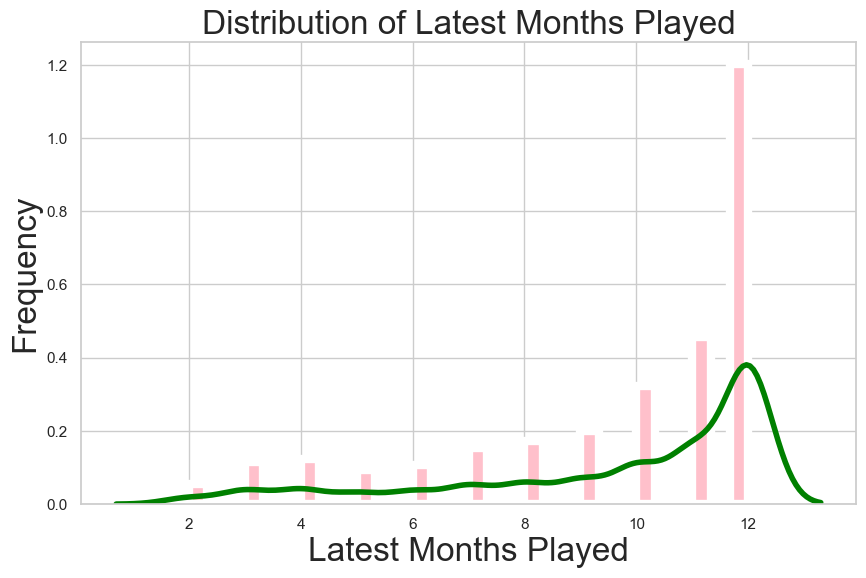

In [29]:
# Plot the Distribution of Latest Months Played
latest_month_dist = sa_total.groupby('Char_ID')['Latest_Month_Played'].max()

## Figure parameters
plt.figure(figsize = (10,6))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 3})

ax = sns.distplot(latest_month_dist, kde_kws = {"color": "green", "lw": 4, "label": "KDE"},
                  hist_kws = {"linewidth": 6,
                              "alpha": 1, "color": "pink",
                              'label': 'Histogram'})

plt.xlabel('Latest Months Played', fontsize = 24)
plt.ylabel('Frequency', fontsize = 24)
plt.title('Distribution of Latest Months Played', fontsize = 24)

plt.show()

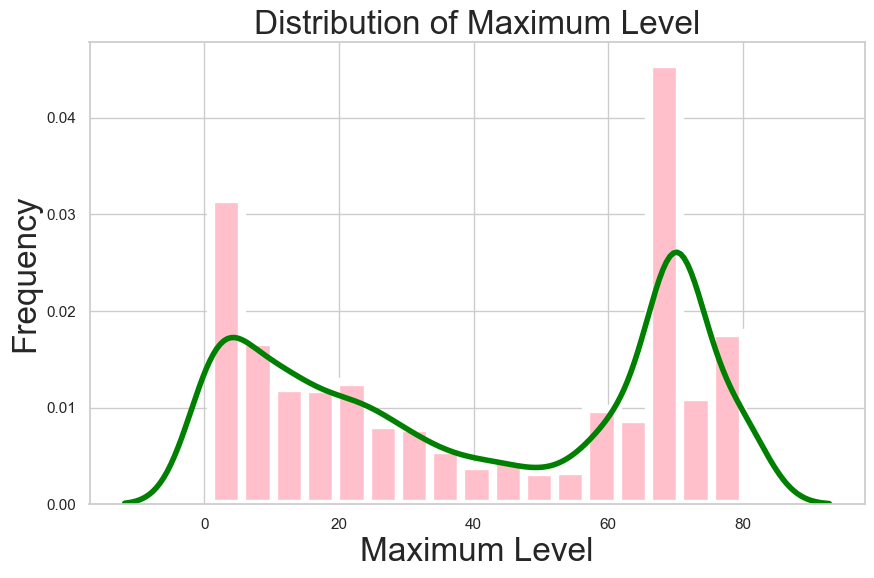

In [30]:
# Plot the Distribution of Levels
max_level_dist = sa_total.groupby('Char_ID')['Max_Level'].max()

## Figure parameters
plt.figure(figsize = (10,6))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 3})

ax = sns.distplot(max_level_dist, kde_kws = {"color": "green", "lw": 4, "label": "KDE"},
                  hist_kws = {"linewidth": 6,
                              "alpha": 1, "color": "pink",
                              'label': 'Histogram'})

plt.xlabel('Maximum Level', fontsize = 24)
plt.ylabel('Frequency', fontsize = 24)
plt.title('Distribution of Maximum Level', fontsize = 24)

plt.show()

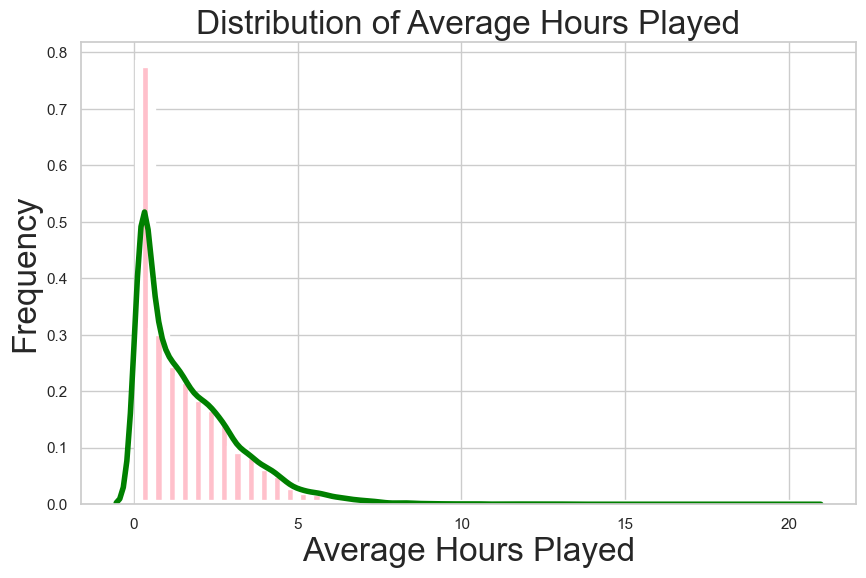

In [31]:
# Plot the Distribution of Average Hours
average_hour_dist = sa_total.groupby('Char_ID')['Average_Hour'].max()

## Figure parameters
plt.figure(figsize = (10,6))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 3})

ax = sns.distplot(average_hour_dist, kde_kws = {"color": "green", "lw": 4, "label": "KDE"},
                  hist_kws = {"linewidth": 6,
                              "alpha": 1, "color": "pink",
                              'label': 'Histogram'})

plt.xlabel('Average Hours Played', fontsize = 24)
plt.ylabel('Frequency', fontsize = 24)
plt.title('Distribution of Average Hours Played', fontsize = 24)

plt.show()

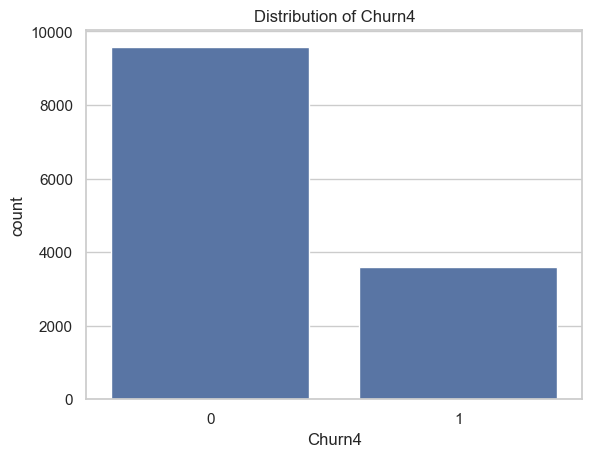

In [32]:
# Plot the Distribution of Churners
sns.countplot(x="Churn4", data=sa_total)
plt.title("Distribution of Churn4")
plt.show()

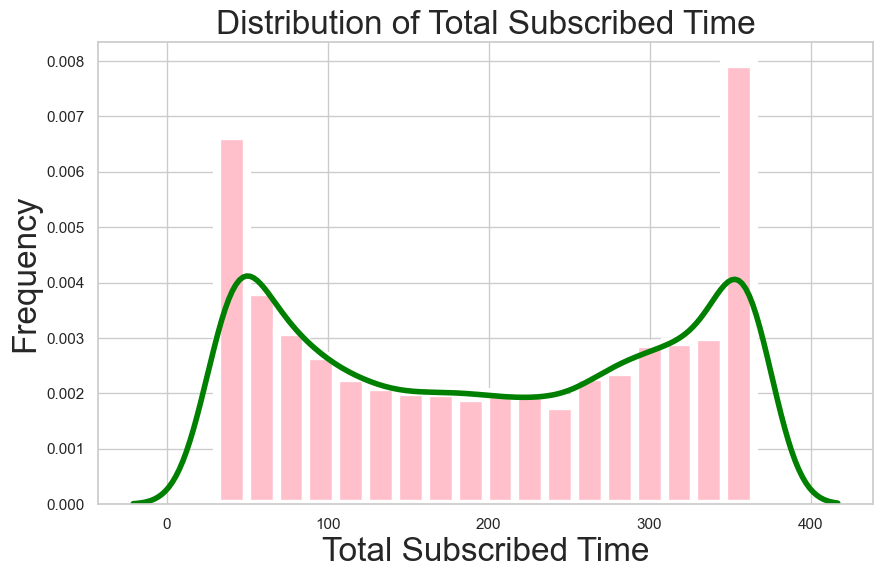

In [33]:
# Plot the Distribution of the Total Subscribed Time 
difference_dist = sa_total.groupby('Char_ID')['Difference'].max()

## Figure parameters
plt.figure(figsize = (10,6))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 3})

ax = sns.distplot(difference_dist, kde_kws = {"color": "green", "lw": 4, "label": "KDE"},
                  hist_kws = {"linewidth": 6,
                              "alpha": 1, "color": "pink",
                              'label': 'Histogram'})

plt.xlabel('Total Subscribed Time', fontsize = 24)
plt.ylabel('Frequency', fontsize = 24)
plt.title('Distribution of Total Subscribed Time', fontsize = 24)

plt.show()

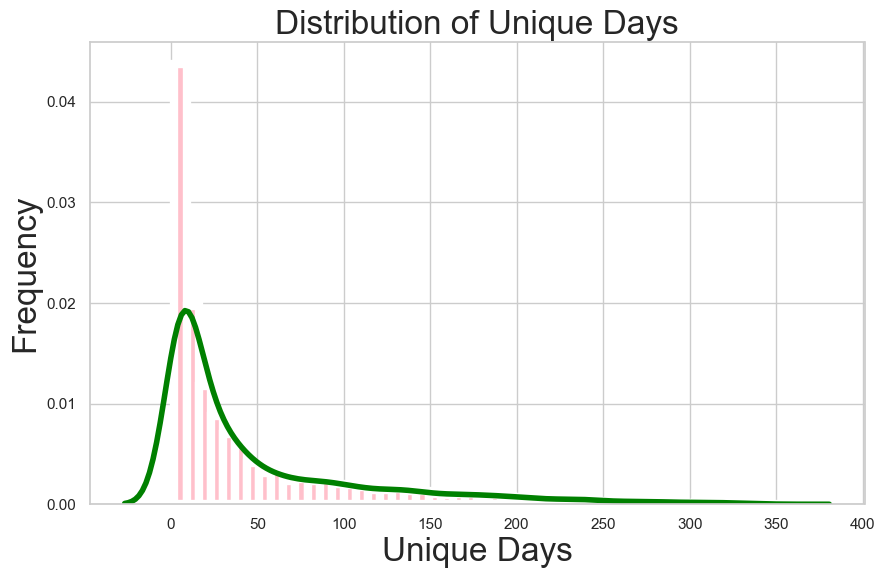

In [34]:
# Plot the Distribution of Unique Days 
unique_days_dist = sa_total.groupby('Char_ID')['Unique_Days'].max()

## Figure parameters
plt.figure(figsize = (10,6))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 3})

ax = sns.distplot(unique_days_dist, kde_kws = {"color": "green", "lw": 4, "label": "KDE"},
                  hist_kws = {"linewidth": 6,
                              "alpha": 1, "color": "pink",
                              'label': 'Histogram'})

plt.xlabel('Unique Days', fontsize = 24)
plt.ylabel('Frequency', fontsize = 24)
plt.title('Distribution of Unique Days', fontsize = 24)

plt.show()

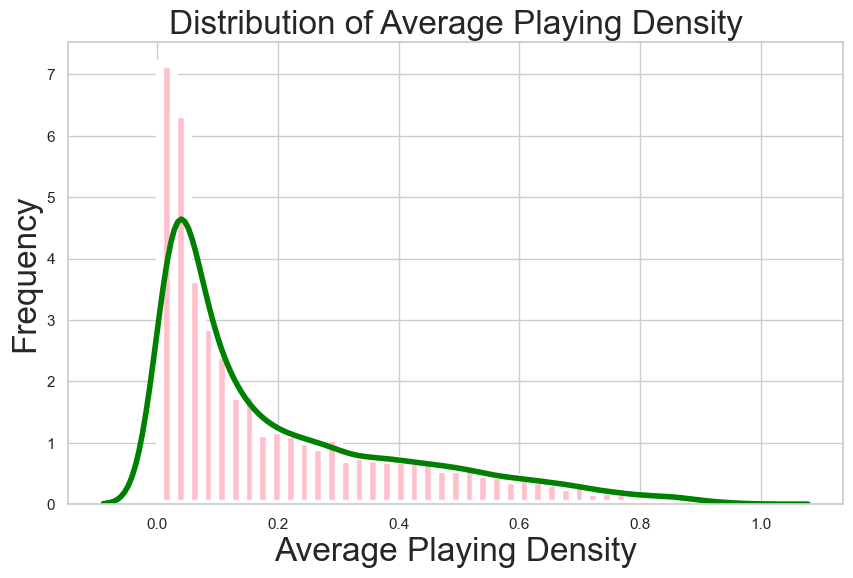

In [35]:
# Plot the Distribution of Average Playing Density 
average_playing_density_dist = sa_total.groupby('Char_ID')['Average_Playing_Density'].max()

## Figure parameters
plt.figure(figsize = (10,6))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 3})

ax = sns.distplot(average_playing_density_dist, kde_kws = {"color": "green", "lw": 4, "label": "KDE"},
                  hist_kws = {"linewidth": 6,
                              "alpha": 1, "color": "pink",
                              'label': 'Histogram'})

plt.xlabel('Average Playing Density', fontsize = 24)
plt.ylabel('Frequency', fontsize = 24)
plt.title('Distribution of Average Playing Density', fontsize = 24)

plt.show()

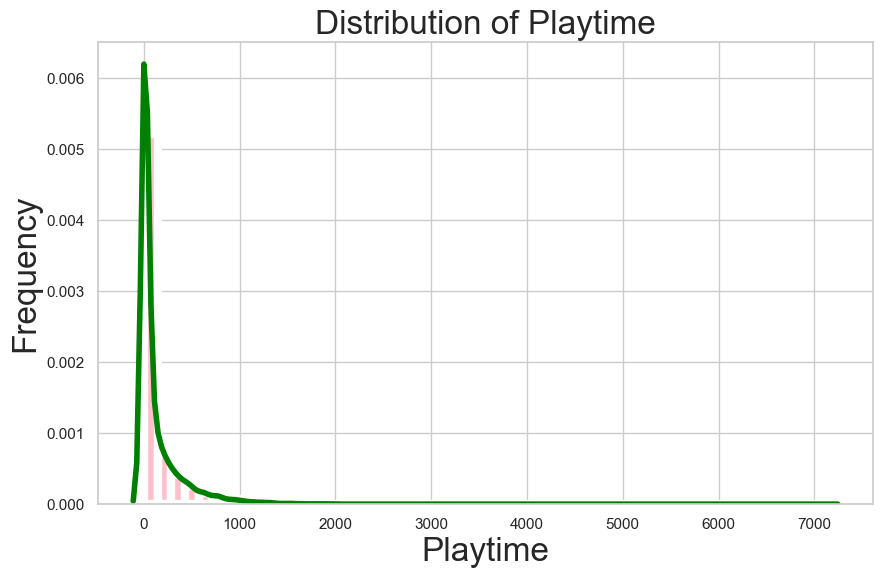

In [36]:
# Plot the Distribution of Playtime
playtime_dist = sa_total.groupby('Char_ID')['Playtime'].max()

## Figure parameters
plt.figure(figsize = (10,6))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 3})

ax = sns.distplot(playtime_dist, kde_kws = {"color": "green", "lw": 4, "label": "KDE"},
                  hist_kws = {"linewidth": 6,
                              "alpha": 1, "color": "pink",
                              'label': 'Histogram'})

plt.xlabel('Playtime', fontsize = 24)
plt.ylabel('Frequency', fontsize = 24)
plt.title('Distribution of Playtime', fontsize = 24)

plt.show()

# PART II - Preparing the data for Survival and Regression Tasks

In [41]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import optuna
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index

import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# Fixed random seed for reproducing reuslts
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [66]:
# Identifying T and E for Survival Analysis
# T (time-to-event) и E (event = churn)
sa_total['T'] = sa_total['Difference']
sa_total['E'] = sa_total['Churn4']

# Log-transform of Playtime: log1p(x) = log(1+x)
sa_total['Log_Playtime'] = np.log1p(sa_total['Playtime'])

# Mask for churned players (E=1)
churned_mask = sa_total['E'] == 1

# Feature set
features = ['Average_Playing_Density', 'Average_Hour', 'Guild', 'Unique_Days']

# Defining feature set and target variables
X = sa_total[features]
T = sa_total['T']
E = sa_total['E']
Level = sa_total['Max_Level']
Log_Playtime = sa_total['Log_Playtime']

In [68]:
# Standardization of features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=features)

In [78]:
# Creating datasets for Survival analysis and Regression Tasks separately
# Survival (churn + non-churn)
survival_data = sa_total[features + ['T', 'E']].copy()

X_survival = survival_data[features]
X_survival_scaled = scaler.fit_transform(X_survival)
X_survival_scaled = pd.DataFrame(X_survival_scaled, columns=features)

survival_data = X_survival_scaled.copy()
survival_data['T'] = sa_total['T'].values
survival_data['E'] = sa_total['E'].values


# Regression (churned only)
churned_players = sa_total[churned_mask].reset_index(drop=True)
X_regression = churned_players[features]
Level = churned_players['Max_Level']
Log_Playtime = churned_players['Log_Playtime']

# Standardizing
X_regression_scaled = scaler.transform(X_regression)
X_regression_scaled = pd.DataFrame(X_regression_scaled, columns=features)

# Creating dataset for regression tasks
regression_data = X_regression_scaled.copy()
regression_data['Level'] = Level
regression_data['Log_Playtime'] = Log_Playtime

#### Train / Validation / Test

In [81]:
print(survival_data['E'].isna().sum())

0


In [87]:
print(regression_data['Log_Playtime'].isna().sum())

0


In [91]:
print(survival_data)

       Average_Playing_Density  Average_Hour     Guild  Unique_Days    T  E
0                    -0.317990      0.330716  0.747734     0.020392  348  0
1                     2.505760      1.133672  0.747734     1.318643  180  1
2                     0.565739      0.400908 -1.337375     0.004751  124  0
3                     0.976229      1.085129  0.747734     1.568909  357  0
4                     1.603729     -0.249997  0.747734     2.319705  361  0
...                        ...           ...       ...          ...  ... ..
13171                 0.753989     -0.420285 -1.337375    -0.417572   32  0
13172                 1.459927      0.078057  0.747734    -0.276798   31  0
13173                 1.146177      0.169202  0.747734    -0.339364   31  0
13174                 0.832427      1.191151  0.747734    -0.401930   31  0
13175                -0.187261     -0.226447  0.747734    -0.605271   31  0

[13176 rows x 6 columns]


In [89]:
print(regression_data)

      Average_Playing_Density  Average_Hour     Guild  Unique_Days  Level  \
0                    2.505760      1.133672  0.747734     1.318643     70   
1                   -0.846136     -0.938972 -1.337375    -0.699120     60   
2                    2.270448      0.551576  0.747734     1.177869     70   
3                   -0.579448      0.780732  0.747734    -0.605271     70   
4                   -0.030386      0.470517  0.747734    -0.104740     70   
...                       ...           ...       ...          ...    ...   
3600                -0.736323     -0.858612 -1.337375    -0.714762      4   
3601                -0.657886     -0.938972 -1.337375    -0.699120      1   
3602                 1.381490      2.695086  0.747734    -0.292439     61   
3603                -0.736323     -0.608603 -1.337375    -0.714762      8   
3604                -0.579448     -0.151444 -1.337375    -0.683479     14   

      Log_Playtime  
0         6.125777  
1         0.606136  
2         5.

In [93]:
# Splitting survival data points
train_surv, temp_surv = train_test_split(survival_data, test_size=0.3, random_state=SEED, stratify=survival_data['E'])
val_surv, test_surv = train_test_split(temp_surv, test_size=0.5, random_state=SEED, stratify=temp_surv['E'])

# Splitting regression data points
train_reg, temp_reg = train_test_split(regression_data, test_size=0.3, random_state=SEED)
val_reg, test_reg = train_test_split(temp_reg, test_size=0.5, random_state=SEED)

# PART III - Baseline Models

#### Survival Baselines

##### Kaplan–Meier Estimator

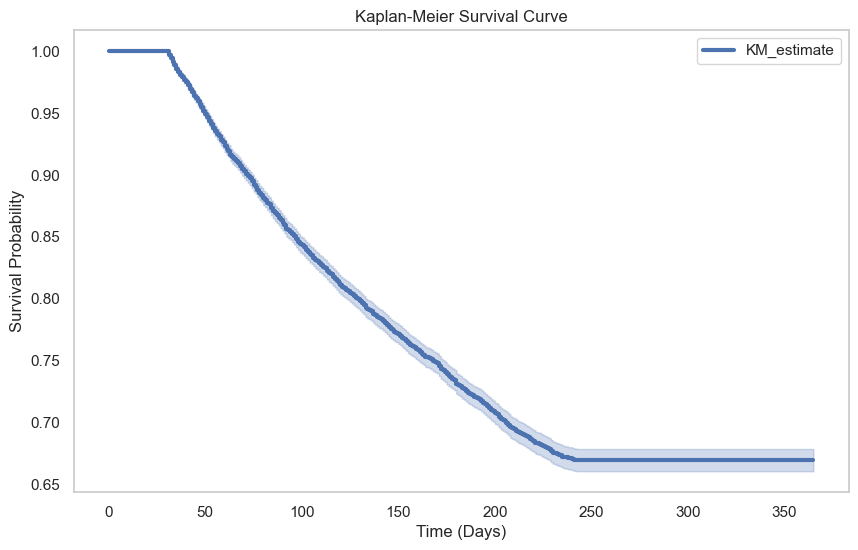

In [102]:
# Kaplan-Meier object
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier to survival data
kmf.fit(durations=survival_data['T'], event_observed=survival_data['E'])

# Plotting the Kaplan-Meier curve
plt.figure(figsize=(10,6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')
plt.grid()
plt.show()

##### Cox Proportional Hazards Model

In [104]:
# Define the sets for CoxPH
cox_train = train_surv.copy()
cox_val = val_surv.copy()
cox_test = test_surv.copy()

# Training the model
cox_model = CoxPHFitter()
cox_model.fit(cox_train, duration_col='T', event_col='E')

# Output the coefficients of the model
print("Coefficients of Cox model:")
cox_model.print_summary()

# Evaluate the metrics
# C-Index measures how well the model ranks players by risk of exit.
train_cindex = concordance_index(train_surv['T'], -cox_model.predict_partial_hazard(train_surv), train_surv['E'])
val_cindex = concordance_index(val_surv['T'], -cox_model.predict_partial_hazard(val_surv), val_surv['E'])
test_cindex = concordance_index(test_surv['T'], -cox_model.predict_partial_hazard(test_surv), test_surv['E'])

print(f"C-Index on Train: {train_cindex:.4f}")
print(f"C-Index on Validation: {val_cindex:.4f}")
print(f"C-Index on Test: {test_cindex:.4f}")

Coefficients of Cox model:


<lifelines.CoxPHFitter: fitted with 9223 total observations, 6700 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 9223
number of events observed = 2523
   partial log-likelihood = -20282.54
         time fit was run = 2025-04-27 02:54:08 UTC

---
                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                
Average_Playing_Density  1.93      6.87      0.04            1.84            2.01                6.31                7.47
Average_Hour             0.15      1.16      0.02            0.10            0.20                1.11                1.22
Guild                   -0.10      0.91      0.02           -0.14           -0.05                0.87                0.95
Unique_Days             -4.58      0.01      0.12           -4.82           -4.35                0.01                0.01

                         cmp to      z      p  -log2(p)
covariate                                              
Average_Playing_Density    0.00  44.99 <0.005       inf
Average_Hour               0.00   6.06 <0.005     29.47
Guild                      0.00  -4.56 <0.005     17.56
Unique_Days                0.00 -38.61 <0.005       inf
---
Concordance = 0.88
Partial AIC = 40573.08
log-likelihood ratio test = 3704.30 on 4 df
-log2(p) of ll-ratio test = inf

C-Index on Train: 0.8833
C-Index on Validation: 0.8812
C-Index on Test: 0.8844


#### Regression Baselines

In [113]:
# First we create the function for measuring the models performance by MAE and MSE

def evaluate_regression_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    test_preds = model.predict(X_test)

    print("Train MAE:", mean_absolute_error(y_train, train_preds))
    print("Validation MAE:", mean_absolute_error(y_val, val_preds))
    print("Test MAE:", mean_absolute_error(y_test, test_preds))
    print("\nTrain MSE:", mean_squared_error(y_train, train_preds))
    print("Validation MSE:", mean_squared_error(y_val, val_preds))
    print("Test MSE:", mean_squared_error(y_test, test_preds))

##### Baseline: Dummy Regressor

In [116]:
# Dummy Regressor
print("\nBaseline Dummy Regressor for Level Prediction:")
dummy_level = DummyRegressor(strategy='median')
evaluate_regression_model(dummy_level, 
                           train_reg[features], train_reg['Level'],
                           val_reg[features], val_reg['Level'],
                           test_reg[features], test_reg['Level'])

print("\nBaseline Dummy Regressor for Log_Playtime Prediction:")
dummy_playtime = DummyRegressor(strategy='median')
evaluate_regression_model(dummy_playtime, 
                           train_reg[features], train_reg['Log_Playtime'],
                           val_reg[features], val_reg['Log_Playtime'],
                           test_reg[features], test_reg['Log_Playtime'])


Baseline Dummy Regressor for Level Prediction:
Train MAE: 20.46730083234245
Validation MAE: 21.493530499075785
Test MAE: 21.824399260628464

Train MSE: 669.9036860879905
Validation MSE: 716.8022181146026
Test MSE: 740.8336414048059

Baseline Dummy Regressor for Log_Playtime Prediction:
Train MAE: 1.3976112604141235
Validation MAE: 1.4483236074447632
Test MAE: 1.4376877546310425

Train MSE: 3.0009727478027344
Validation MSE: 3.182701587677002
Test MSE: 3.213050365447998


##### Linear Regression with Optuna Hyperparameter Tuning

In [123]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [119]:
# Here we will select the best linear model type (regular, Ridge, Lasso) and regularization parameter via Optuna

def objective_linear(trial, X_train, y_train, X_val, y_val):
    model_type = trial.suggest_categorical('model_type', ['Linear', 'Ridge', 'Lasso'])
    alpha = trial.suggest_float('alpha', 1e-5, 10.0, log=True)

    if model_type == 'Linear':
        model = LinearRegression()
    elif model_type == 'Ridge':
        model = Ridge(alpha=alpha)
    else:
        model = Lasso(alpha=alpha)

    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_preds)

    return val_mae

In [125]:
# Level Prediction
print("\nOptuna tuning for Level Prediction:")
study_level = optuna.create_study(direction='minimize')
study_level.optimize(lambda trial: objective_linear(trial, 
                                                    train_reg[features], train_reg['Level'],
                                                    val_reg[features], val_reg['Level']),
                     n_trials=50)

print("Best parameters for Level Prediction:", study_level.best_params)


[I 2025-04-27 08:27:46,869] A new study created in memory with name: no-name-0e3efe93-442c-44a3-8ff8-a2dce50acc70
[I 2025-04-27 08:27:46,880] Trial 0 finished with value: 13.314000072784962 and parameters: {'model_type': 'Ridge', 'alpha': 0.00032334891627339027}. Best is trial 0 with value: 13.314000072784962.
[I 2025-04-27 08:27:46,892] Trial 1 finished with value: 13.315876601451434 and parameters: {'model_type': 'Lasso', 'alpha': 0.008131855389893009}. Best is trial 0 with value: 13.314000072784962.
[I 2025-04-27 08:27:46,897] Trial 2 finished with value: 13.314000913968611 and parameters: {'model_type': 'Ridge', 'alpha': 0.0012574564211856184}. Best is trial 0 with value: 13.314000072784962.
[I 2025-04-27 08:27:46,905] Trial 3 finished with value: 13.313999781600545 and parameters: {'model_type': 'Linear', 'alpha': 0.0031375727384462446}. Best is trial 3 with value: 13.313999781600545.
[I 2025-04-27 08:27:46,912] Trial 4 finished with value: 13.313999781600545 and parameters: {'mod


Optuna tuning for Level Prediction:


[I 2025-04-27 08:27:47,063] Trial 19 finished with value: 13.314001233964941 and parameters: {'model_type': 'Ridge', 'alpha': 0.001612804407342421}. Best is trial 3 with value: 13.313999781600545.
[I 2025-04-27 08:27:47,076] Trial 20 finished with value: 13.313999781600545 and parameters: {'model_type': 'Linear', 'alpha': 1.5657873866108485}. Best is trial 3 with value: 13.313999781600545.
[I 2025-04-27 08:27:47,087] Trial 21 finished with value: 13.313999781600545 and parameters: {'model_type': 'Linear', 'alpha': 9.014606239873434}. Best is trial 3 with value: 13.313999781600545.
[I 2025-04-27 08:27:47,099] Trial 22 finished with value: 13.313999781600545 and parameters: {'model_type': 'Linear', 'alpha': 2.29122696709646}. Best is trial 3 with value: 13.313999781600545.
[I 2025-04-27 08:27:47,117] Trial 23 finished with value: 13.313999781600545 and parameters: {'model_type': 'Linear', 'alpha': 0.13545499633963315}. Best is trial 3 with value: 13.313999781600545.
[I 2025-04-27 08:27:4

Best parameters for Level Prediction: {'model_type': 'Linear', 'alpha': 0.0031375727384462446}


In [127]:
# We train the final model with the best parameters
best_params_level = study_level.best_params
if best_params_level['model_type'] == 'Linear':
    final_model_level = LinearRegression()
elif best_params_level['model_type'] == 'Ridge':
    final_model_level = Ridge(alpha=best_params_level['alpha'])
else:
    final_model_level = Lasso(alpha=best_params_level['alpha'])

evaluate_regression_model(final_model_level,
                           train_reg[features], train_reg['Level'],
                           val_reg[features], val_reg['Level'],
                           test_reg[features], test_reg['Level'])

Train MAE: 12.873091640315485
Validation MAE: 13.313999781600545
Test MAE: 13.492947756592958

Train MSE: 273.2911578172666
Validation MSE: 289.43266524026944
Test MSE: 297.4838467284105


In [129]:
# Log_Playtime Prediction
print("\nOptuna tuning for Log_Playtime Prediction:")
study_playtime = optuna.create_study(direction='minimize')
study_playtime.optimize(lambda trial: objective_linear(trial, 
                                                       train_reg[features], train_reg['Log_Playtime'],
                                                       val_reg[features], val_reg['Log_Playtime']),
                        n_trials=50)

print("Best parameters for Log_Playtime Prediction:", study_playtime.best_params)

[I 2025-04-27 08:27:51,868] A new study created in memory with name: no-name-2e7a8e04-297c-41b8-9e10-1beec39c9e67
[I 2025-04-27 08:27:51,875] Trial 0 finished with value: 0.5090072705142902 and parameters: {'model_type': 'Lasso', 'alpha': 0.004347716223452615}. Best is trial 0 with value: 0.5090072705142902.
[I 2025-04-27 08:27:51,880] Trial 1 finished with value: 0.5085355293854825 and parameters: {'model_type': 'Ridge', 'alpha': 6.701028085239149}. Best is trial 1 with value: 0.5085355293854825.
[I 2025-04-27 08:27:51,886] Trial 2 finished with value: 0.5091394537926494 and parameters: {'model_type': 'Ridge', 'alpha': 0.060641820461760414}. Best is trial 1 with value: 0.5085355293854825.
[I 2025-04-27 08:27:51,891] Trial 3 finished with value: 1.2520837292453555 and parameters: {'model_type': 'Lasso', 'alpha': 1.1349902754420085}. Best is trial 1 with value: 0.5085355293854825.
[I 2025-04-27 08:27:51,897] Trial 4 finished with value: 0.5091458526789029 and parameters: {'model_type': 


Optuna tuning for Log_Playtime Prediction:


[I 2025-04-27 08:27:52,067] Trial 22 finished with value: 0.5086269714307893 and parameters: {'model_type': 'Ridge', 'alpha': 5.576505162087836}. Best is trial 14 with value: 0.5083283382567279.
[I 2025-04-27 08:27:52,077] Trial 23 finished with value: 0.5083820273752324 and parameters: {'model_type': 'Ridge', 'alpha': 8.882195684538539}. Best is trial 14 with value: 0.5083283382567279.
[I 2025-04-27 08:27:52,088] Trial 24 finished with value: 0.5090686713937298 and parameters: {'model_type': 'Ridge', 'alpha': 0.7390084089677416}. Best is trial 14 with value: 0.5083283382567279.
[I 2025-04-27 08:27:52,098] Trial 25 finished with value: 0.5091403667495462 and parameters: {'model_type': 'Ridge', 'alpha': 0.051982940963785494}. Best is trial 14 with value: 0.5083283382567279.
[I 2025-04-27 08:27:52,108] Trial 26 finished with value: 0.5089154429532897 and parameters: {'model_type': 'Ridge', 'alpha': 2.2637561093845795}. Best is trial 14 with value: 0.5083283382567279.
[I 2025-04-27 08:27:

Best parameters for Log_Playtime Prediction: {'model_type': 'Ridge', 'alpha': 9.8856754784891}


In [131]:
# We train the final model with the best parameters
best_params_playtime = study_playtime.best_params
if best_params_playtime['model_type'] == 'Linear':
    final_model_playtime = LinearRegression()
elif best_params_playtime['model_type'] == 'Ridge':
    final_model_playtime = Ridge(alpha=best_params_playtime['alpha'])
else:
    final_model_playtime = Lasso(alpha=best_params_playtime['alpha'])

evaluate_regression_model(final_model_playtime,
                           train_reg[features], train_reg['Log_Playtime'],
                           val_reg[features], val_reg['Log_Playtime'],
                           test_reg[features], test_reg['Log_Playtime'])


Train MAE: 0.5012405454463044
Validation MAE: 0.5083150672015313
Test MAE: 0.5099658728368063

Train MSE: 0.37488846695559414
Validation MSE: 0.3777854237107527
Test MSE: 0.3753356033975404


##### Random Forest Regression with Optuna Hyperparameter Tuning

In [136]:
# Defining an Optimization Function for Optuna

def objective_random_forest(trial, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=SEED
    )

    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_preds)

    return val_mae

In [138]:
# For Level Prediction
print("\nOptuna tuning for Random Forest Level Prediction:")
study_rf_level = optuna.create_study(direction='minimize')
study_rf_level.optimize(lambda trial: objective_random_forest(trial, 
                                                              train_reg[features], train_reg['Level'],
                                                              val_reg[features], val_reg['Level']),
                        n_trials=50)

print("Best parameters for Random Forest Level Prediction:", study_rf_level.best_params)


[I 2025-04-27 08:57:14,916] A new study created in memory with name: no-name-eee42114-be70-4d00-9c15-6fe87784d7f6



Optuna tuning for Random Forest Level Prediction:


[I 2025-04-27 08:57:15,382] Trial 0 finished with value: 12.107692681682364 and parameters: {'n_estimators': 110, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 12.107692681682364.
[I 2025-04-27 08:57:15,553] Trial 1 finished with value: 12.090147972819898 and parameters: {'n_estimators': 74, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 12.090147972819898.
[I 2025-04-27 08:57:15,856] Trial 2 finished with value: 11.902102931849742 and parameters: {'n_estimators': 86, 'max_depth': 24, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 2 with value: 11.902102931849742.
[I 2025-04-27 08:57:16,128] Trial 3 finished with value: 12.154794273255417 and parameters: {'n_estimators': 142, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 11.902102931849742.
[I

Best parameters for Random Forest Level Prediction: {'n_estimators': 56, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': None}


In [140]:
# Train the final model with the best parameters
best_params_rf_level = study_rf_level.best_params
final_rf_model_level = RandomForestRegressor(
    n_estimators=best_params_rf_level['n_estimators'],
    max_depth=best_params_rf_level['max_depth'],
    min_samples_split=best_params_rf_level['min_samples_split'],
    min_samples_leaf=best_params_rf_level['min_samples_leaf'],
    max_features=best_params_rf_level['max_features'],
    random_state=SEED
)

evaluate_regression_model(final_rf_model_level,
                           train_reg[features], train_reg['Level'],
                           val_reg[features], val_reg['Level'],
                           test_reg[features], test_reg['Level'])


Train MAE: 10.250666434401117
Validation MAE: 11.75278701393505
Test MAE: 11.822703663365406

Train MSE: 195.91994493369157
Validation MSE: 256.4342267886305
Test MSE: 262.5573946331102


In [142]:
# For Log_Playtime Prediction
print("\nOptuna tuning for Random Forest Log_Playtime Prediction:")
study_rf_playtime = optuna.create_study(direction='minimize')
study_rf_playtime.optimize(lambda trial: objective_random_forest(trial, 
                                                                 train_reg[features], train_reg['Log_Playtime'],
                                                                 val_reg[features], val_reg['Log_Playtime']),
                           n_trials=50)

print("Best parameters for Random Forest Log_Playtime Prediction:", study_rf_playtime.best_params)

[I 2025-04-27 08:58:11,505] A new study created in memory with name: no-name-b41cc2fe-f3ed-4058-b83d-82b2f8c9ac13



Optuna tuning for Random Forest Log_Playtime Prediction:


[I 2025-04-27 08:58:12,017] Trial 0 finished with value: 0.03915620084298014 and parameters: {'n_estimators': 155, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.03915620084298014.
[I 2025-04-27 08:58:12,245] Trial 1 finished with value: 0.06748349457258229 and parameters: {'n_estimators': 97, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.03915620084298014.
[I 2025-04-27 08:58:12,372] Trial 2 finished with value: 0.10190497851411755 and parameters: {'n_estimators': 59, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.03915620084298014.
[I 2025-04-27 08:58:12,504] Trial 3 finished with value: 0.07962660435283231 and parameters: {'n_estimators': 54, 'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.039156200

Best parameters for Random Forest Log_Playtime Prediction: {'n_estimators': 164, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}


In [144]:
# Train the final model with the best parameters
best_params_rf_playtime = study_rf_playtime.best_params
final_rf_model_playtime = RandomForestRegressor(
    n_estimators=best_params_rf_playtime['n_estimators'],
    max_depth=best_params_rf_playtime['max_depth'],
    min_samples_split=best_params_rf_playtime['min_samples_split'],
    min_samples_leaf=best_params_rf_playtime['min_samples_leaf'],
    max_features=best_params_rf_playtime['max_features'],
    random_state=SEED
)

evaluate_regression_model(final_rf_model_playtime,
                           train_reg[features], train_reg['Log_Playtime'],
                           val_reg[features], val_reg['Log_Playtime'],
                           test_reg[features], test_reg['Log_Playtime'])

Train MAE: 0.009442938693752559
Validation MAE: 0.022810615229982754
Test MAE: 0.020401444685107958

Train MSE: 0.00045260636415280555
Validation MSE: 0.0038492961791859563
Test MSE: 0.00198478394598499


# PART IV - The Multitask Neural Network

#### Multi-Task Model Architecture

In [375]:
# PyTorch Dataset for a multitask task
class MultitaskDataset(Dataset):
    def __init__(self, features, T, E, Level, Log_Playtime):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.T = torch.tensor(T.values, dtype=torch.float32)
        self.E = torch.tensor(E.values, dtype=torch.float32)
        self.Level = torch.tensor(Level.values, dtype=torch.float32)
        self.Log_Playtime = torch.tensor(Log_Playtime.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.T[idx], self.E[idx], self.Level[idx], self.Log_Playtime[idx]

In [377]:
# Multitask Neural Network architecture
class MultitaskNet(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(MultitaskNet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        # Outputs for different tasks
        self.survival_head = nn.Linear(hidden_size, 1)  # for survival
        self.level_head = nn.Linear(hidden_size, 1)     # for level
        self.playtime_head = nn.Linear(hidden_size, 1)  # for playtime

    def forward(self, x):
        shared = self.shared(x)
        risk = self.survival_head(shared)
        level = self.level_head(shared)
        playtime = self.playtime_head(shared)
        return risk, level, playtime


#### Preparing DataLoaders and starting model training

In [380]:
# Adding blank Level and Log_Playtime for non-churners
for df_surv, df_reg in [(train_surv, train_reg), (val_surv, val_reg), (test_surv, test_reg)]:
    df_surv['Level'] = np.nan
    df_surv['Log_Playtime'] = np.nan
    churned_mask = df_surv['E'] == 1
    df_surv.loc[churned_mask, 'Level'] = df_reg['Level'].values
    df_surv.loc[churned_mask, 'Log_Playtime'] = df_reg['Log_Playtime'].values

In [382]:
for df in [train_surv, val_surv, test_surv]:
    df['Level'] = df['Level'] / 60.0

In [384]:
# Creating Multitask Datasets for train, validation and test
train_dataset = MultitaskDataset(train_surv[features], train_surv['T'], train_surv['E'],
                                 train_surv['Level'], train_surv['Log_Playtime'])

val_dataset = MultitaskDataset(val_surv[features], val_surv['T'], val_surv['E'],
                               val_surv['Level'], val_surv['Log_Playtime'])

test_dataset = MultitaskDataset(test_surv[features], test_surv['T'], test_surv['E'],
                                test_surv['Level'], test_surv['Log_Playtime'])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#### Loss Function, Training and Optimization

In [387]:
# Loss Function
def multitask_loss(risk_pred, T, E, level_pred, Level, playtime_pred, Playtime,
                   weight_survival=5.0, weight_level=1.0, weight_playtime=1.0):
    #Survival Loss
    survival_loss = F.binary_cross_entropy_with_logits(risk_pred.squeeze(), E)
    # Regression Loss
    churn_mask = (E == 1)

    if churn_mask.sum() > 0:
        level_loss = F.mse_loss(level_pred.squeeze()[churn_mask], Level[churn_mask])
        playtime_loss = F.mse_loss(playtime_pred.squeeze()[churn_mask], Playtime[churn_mask])
    else:
        level_loss = torch.tensor(0.0, device=E.device)
        playtime_loss = torch.tensor(0.0, device=E.device)
    # Total Loss
    total_loss = (weight_survival * survival_loss +
                  weight_level * level_loss +
                  weight_playtime * playtime_loss)
    return total_loss, survival_loss, level_loss, playtime_loss

#### Optuna Objective for hyperparameters and weights optimization

In [394]:
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-3, log=True)
    weight_survival = trial.suggest_float('weight_survival', 1.0, 10.0)
    weight_level = trial.suggest_float('weight_level', 0.5, 5.0)
    weight_playtime = trial.suggest_float('weight_playtime', 0.5, 5.0)

    model = MultitaskNet(input_size=len(features), hidden_size=hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for features_batch, T_batch, E_batch, Level_batch, Log_Playtime_batch in train_loader:
        optimizer.zero_grad()
        risk_pred, level_pred, playtime_pred = model(features_batch)
        loss, _, _, _ = multitask_loss(
            risk_pred, T_batch, E_batch, level_pred, Level_batch, playtime_pred, Log_Playtime_batch,
            weight_survival, weight_level, weight_playtime)
        loss.backward()
        optimizer.step()

    model.eval()
    val_losses = []
    with torch.no_grad():
        for features_batch, T_batch, E_batch, Level_batch, Log_Playtime_batch in val_loader:
            risk_pred, level_pred, playtime_pred = model(features_batch)
            loss, _, _, _ = multitask_loss(
                risk_pred, T_batch, E_batch, level_pred, Level_batch, playtime_pred, Log_Playtime_batch,
                weight_survival, weight_level, weight_playtime)
            val_losses.append(loss.item())

    return np.mean(val_losses)


In [396]:
# Launch Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best parameters:", study.best_params)

[I 2025-04-27 11:17:47,784] A new study created in memory with name: no-name-b742c173-ebde-4067-a20b-286d1bf88bb0
[I 2025-04-27 11:17:48,398] Trial 0 finished with value: 6.831406424122472 and parameters: {'hidden_size': 48, 'learning_rate': 0.0011984660672781802, 'weight_survival': 5.2131787463996755, 'weight_level': 1.9943432613367567, 'weight_playtime': 1.2481704267828588}. Best is trial 0 with value: 6.831406424122472.
[I 2025-04-27 11:17:49,065] Trial 1 finished with value: 15.611381530761719 and parameters: {'hidden_size': 246, 'learning_rate': 0.0009410971522556417, 'weight_survival': 7.775649334689779, 'weight_level': 1.7243030510346649, 'weight_playtime': 3.7518065808461}. Best is trial 0 with value: 6.831406424122472.
[I 2025-04-27 11:17:49,686] Trial 2 finished with value: 10.163360411121 and parameters: {'hidden_size': 122, 'learning_rate': 0.002736657845219529, 'weight_survival': 6.843598279057914, 'weight_level': 3.5328333794765117, 'weight_playtime': 2.0275498715692817}.

Best parameters: {'hidden_size': 131, 'learning_rate': 0.0004831886794918075, 'weight_survival': 1.1646909272264718, 'weight_level': 3.9551928213902214, 'weight_playtime': 0.5055294384300254}


In [400]:
# Building the final model with the best parameters
best_params = study.best_params

final_model = MultitaskNet(
    input_size=len(features),
    hidden_size=best_params['hidden_size']
)

optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

#### Initialization of the model

In [403]:
# Training the model

n_epochs = 50
train_losses = []
val_losses = []

for epoch in range(1, n_epochs + 1):
    final_model.train()
    total_train_loss = 0.0
    for features_batch, T_batch, E_batch, Level_batch, Log_Playtime_batch in train_loader:
        optimizer.zero_grad()
        risk_pred, level_pred, playtime_pred = final_model(features_batch)
        loss, _, _, _ = multitask_loss(
            risk_pred, T_batch, E_batch, level_pred, Level_batch, playtime_pred, Log_Playtime_batch,
            best_params['weight_survival'], best_params['weight_level'], best_params['weight_playtime'])
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    final_model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for features_batch, T_batch, E_batch, Level_batch, Log_Playtime_batch in val_loader:
            risk_pred, level_pred, playtime_pred = final_model(features_batch)
            loss, _, _, _ = multitask_loss(
                risk_pred, T_batch, E_batch, level_pred, Level_batch, playtime_pred, Log_Playtime_batch,
                best_params['weight_survival'], best_params['weight_level'], best_params['weight_playtime'])
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch}/{n_epochs}: Train Loss = {avg_train_loss:.4f} | Validation Loss = {avg_val_loss:.4f}")

Epoch 1/50: Train Loss = 3.2396 | Validation Loss = 2.8835
Epoch 2/50: Train Loss = 2.7873 | Validation Loss = 2.8539
Epoch 3/50: Train Loss = 2.7561 | Validation Loss = 2.8292
Epoch 4/50: Train Loss = 2.7163 | Validation Loss = 2.8436
Epoch 5/50: Train Loss = 2.7189 | Validation Loss = 2.8018
Epoch 6/50: Train Loss = 2.7020 | Validation Loss = 2.8270
Epoch 7/50: Train Loss = 2.6718 | Validation Loss = 2.8504
Epoch 8/50: Train Loss = 2.6768 | Validation Loss = 2.7881
Epoch 9/50: Train Loss = 2.6447 | Validation Loss = 2.7763
Epoch 10/50: Train Loss = 2.6747 | Validation Loss = 2.7879
Epoch 11/50: Train Loss = 2.6418 | Validation Loss = 2.7455
Epoch 12/50: Train Loss = 2.6628 | Validation Loss = 2.7550
Epoch 13/50: Train Loss = 2.5969 | Validation Loss = 2.7731
Epoch 14/50: Train Loss = 2.6213 | Validation Loss = 2.7194
Epoch 15/50: Train Loss = 2.6068 | Validation Loss = 2.7220
Epoch 16/50: Train Loss = 2.6108 | Validation Loss = 2.7367
Epoch 17/50: Train Loss = 2.5948 | Validation Los

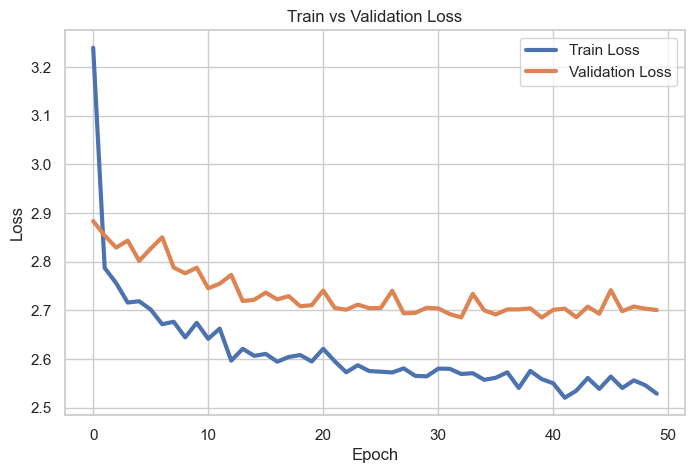

In [405]:
# Train vs Validation Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Model evaluation on the test dataset

In [408]:
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error
from lifelines.utils import concordance_index
import torch.nn.functional as F

In [410]:
def final_evaluate_model(model, test_loader):
    model.eval()
    survival_losses = []
    level_losses = []
    playtime_losses = []

    all_risks = []
    all_E = []
    all_T = []
    all_levels_true = []
    all_levels_pred = []
    all_playtimes_true = []
    all_playtimes_pred = []

    with torch.no_grad():
        for features, T, E, Level, Log_Playtime in test_loader:
            risk_pred, level_pred, playtime_pred = model(features)
            _, survival_loss, level_loss, playtime_loss = multitask_loss(
                risk_pred, T, E, level_pred, Level, playtime_pred, Log_Playtime)

            survival_losses.append(survival_loss.item())
            level_losses.append(level_loss.item())
            playtime_losses.append(playtime_loss.item())

            all_risks.append(risk_pred.squeeze().cpu().numpy())
            all_E.append(E.cpu().numpy())
            all_T.append(T.cpu().numpy())

            churn_mask = (E == 1)
            if churn_mask.sum() > 0:
                all_levels_true.append(Level[churn_mask].cpu().numpy())
                all_levels_pred.append(level_pred.squeeze()[churn_mask].cpu().numpy())
                all_playtimes_true.append(Log_Playtime[churn_mask].cpu().numpy())
                all_playtimes_pred.append(playtime_pred.squeeze()[churn_mask].cpu().numpy())

    avg_survival_loss = np.mean(survival_losses)
    avg_level_loss = np.mean(level_losses)
    avg_playtime_loss = np.mean(playtime_losses)

    all_risks = np.concatenate(all_risks)
    all_E = np.concatenate(all_E)
    all_T = np.concatenate(all_T)

    all_levels_true = np.concatenate(all_levels_true)
    all_levels_pred = np.concatenate(all_levels_pred)
    all_playtimes_true = np.concatenate(all_playtimes_true)
    all_playtimes_pred = np.concatenate(all_playtimes_pred)

    roc_auc = roc_auc_score(all_E, -all_risks)
    c_index = concordance_index(all_T, -all_risks, all_E)

    level_mae = mean_absolute_error(all_levels_true * 60, all_levels_pred * 60)
    level_mse = mean_squared_error(all_levels_true * 60, all_levels_pred * 60)

    playtime_mae = mean_absolute_error(all_playtimes_true, all_playtimes_pred)
    playtime_mse = mean_squared_error(all_playtimes_true, all_playtimes_pred)

    print("\nFinal Test Set Results:")
    print(f"Survival Loss: {avg_survival_loss:.4f}")
    print(f"ROC AUC (Survival Task): {roc_auc:.4f}")
    print(f"Concordance Index (C-Index): {c_index:.4f}")
    print(f"Level Loss: {avg_level_loss:.4f} | MAE: {level_mae:.4f} | MSE: {level_mse:.4f}")
    print(f"Playtime Loss: {avg_playtime_loss:.4f} | MAE: {playtime_mae:.4f} | MSE: {playtime_mse:.4f}")

In [412]:
final_evaluate_model(final_model, test_loader)


Final Test Set Results:
Survival Loss: 0.3998
ROC AUC (Survival Task): 0.1625
Concordance Index (C-Index): 0.8741
Level Loss: 0.1852 | MAE: 22.2149 | MSE: 676.2759
Playtime Loss: 2.9730 | MAE: 1.4712 | MSE: 3.0500


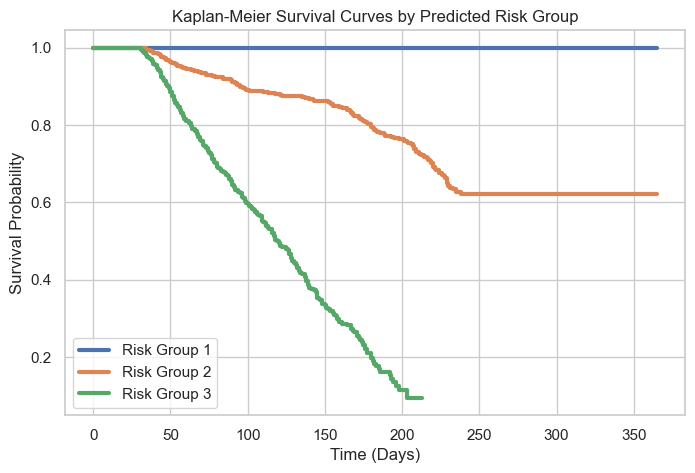

In [414]:
from lifelines import KaplanMeierFitter
import numpy as np
import matplotlib.pyplot as plt

# Сбор предсказаний
final_model.eval()
all_risks = []
all_T = []
all_E = []

with torch.no_grad():
    for features_batch, T_batch, E_batch, _, _ in test_loader:
        risk_pred, _, _ = final_model(features_batch)
        all_risks.append(risk_pred.squeeze().cpu().numpy())
        all_T.append(T_batch.cpu().numpy())
        all_E.append(E_batch.cpu().numpy())

all_risks = np.concatenate(all_risks)
all_T = np.concatenate(all_T)
all_E = np.concatenate(all_E)

# Деление по предсказанному риску
percentiles = np.percentile(all_risks, [33, 66])
risk_groups = np.digitize(all_risks, bins=percentiles)

# Построение Kaplan-Meier кривых
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,5))

for group in range(3):
    mask = (risk_groups == group)
    kmf.fit(all_T[mask], event_observed=all_E[mask], label=f"Risk Group {group+1}")
    kmf.plot_survival_function(ci_show=False)

plt.title('Kaplan-Meier Survival Curves by Predicted Risk Group')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.show()
